# Probability & Statistics 6

Recall our main question Q1: Do first babies tend to arrive late?

Let's relax the question to Q2: Is there a difference in the pregnancy length of first babies (versus others)?

## Classical Hypothesis Testing for Q2

The logic of hypothesis testing is based on "proof by contradiction":

* Choose a **test statistic** : the difference in the means between the group of first babies and the group of other babies.
* Assume the contrary: There is NO DIFFERENCE in the pregnancy length of first babies versus others -- **Null Hypothesis**.
* Calculate the **p-value** : the probability of observing a difference in means as big or bigger than what we saw in the data ASSUMING the null hypothesis is true.
* If the p-value is low, then null hypothesis DOES NOT explain the apparent effect from the data and there is a contradiction of the assumption that the null hypothesis is true. Hence the contrary to the null hypothesis must be true - **statistically significance**.



In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlite3
import pprint

conn = sqlite3.connect('nsfg.db')
curs = conn.cursor()

attr = 'prglngth'

curs.execute('SELECT ' + attr + ' FROM fempreg WHERE ' + attr + ' is not null and birthord=1;')
first =  np.array(curs.fetchall()).flatten()
nfirst = len(first)

curs.execute('SELECT ' + attr + ' FROM fempreg WHERE ' + attr + ' is not null and birthord>1;')
other =  np.array(curs.fetchall()).flatten()
nother = len(other)

# test statistic
diffmeans = abs(first.mean() - other.mean())
print('Mean prglngth of first = ' + str(first.mean()))
print('Mean prglngth of other = ' + str(other.mean()))
print('Difference in means between first babies and others = ' + str(diffmeans))

Mean prglngth of first = 38.5712422563
Mean prglngth of other = 38.3690824079
Difference in means between first babies and others = 0.202159848328


### How to compute the p-value under the null hypothesis?

Null hypothesis: there is no difference in the means of the two groups.

How do we simulate a "sampling distribution" under the null hypothesis?

Idea 1: Combine the two groups, randomly permute the sequence, and split the sequence into two groups again.

P-Value = 0.001


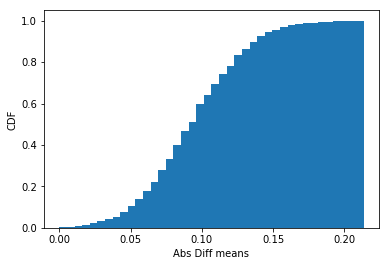

In [41]:
data = np.hstack((first,other))
niters = 1000

# Simulate the data of the sampling distribution
dm = []
for _ in range(niters):
    np.random.shuffle(data)
    newfirst = data[:nfirst]
    newother = data[nfirst:]
    dm.append(abs(newfirst.mean()-other.mean()))

# Calculate the frequency in the simulated sampling distribution data where 
# the diff means is greater than the observed diff means
cnt = 0.0
for d in dm:
    if d >= diffmeans:
        cnt += 1.0

pvalue = cnt/niters

print('P-Value = ' + str(pvalue))

plt.hist(dm, bins=40, normed=True, cumulative=True)
plt.ylabel('CDF')
plt.xlabel('Abs Diff means')
plt.show()

#dmcdf, dmbins = np.histogram(dm, bins=40, density=True)
#print(dmcdf)
#print(dmbins)


### How low must the p-value be?

By convention p-value < 0.05 is considered statistically significant.

From TS: 

* if the p-value is less than 1%, the effect is unlikely to be due to chance; 
* if it is greater than 10%, the effect can plausibly be explained by chance. 
* P-values between 1% and 10% should be considered borderline.

Since p-value < 0.01, we conclude that there is a difference in the means of the pregnancy lengths between first babies and others

## What about Q1: Do first babies arrive late?

Test statistic: first.mean() - other.mean() 

* No absolute value! 
* Positive & negative differences matters, but Q1 only concern with positive difference - **one-tail test**
* Q2 did not care whether the difference was positive or negative, i.e., it can be satisfied by either positive or negative difference  -- ** two-tail test **

Without programming the simulation, guess the result for Q1.

## Exercise : Test for the statistical significance of Q3 

### Q3 : Is birth weight correlated to pregnancy length

Read TS Ch. 9.5

1. Define the **Test Statistic**
2. State the **Null Hypothesis**
3. Compute the **p-value** under the null hypothesis. How would you simulate the sampling distribution?
4. Interpret the **statistical significance**

In [42]:
# get birth weight data
curs.execute('SELECT birthwgt_lb1 + (birthwgt_oz1/16.0), prglngth '
             + 'FROM fempreg WHERE birthwgt_lb1 is not null '
             + 'AND birthwgt_oz1 is not null '
             + 'AND birthwgt_lb1 < 25 '
             + ';')

data = np.array(curs.fetchall())
#print(data)

# dice the weight 
wgt = data[:,0]
# dice pregnancy length
plen = data[:,1]

print('Data loaded!')

Data loaded!


Pearson's Correlation = 0.51894520742
P-Value (random correlation >= 0.51894520742) = 0.0


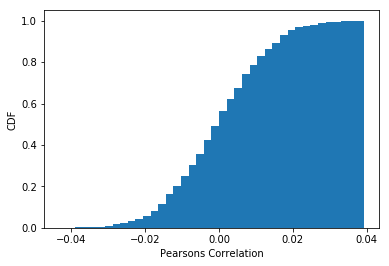

In [43]:
pcorr,pv = stats.pearsonr(wgt,plen)

print('Pearson\'s Correlation = ' + str(pcorr))

# To simulate random chance under null hypothesis, randomly permute the plen array
niters = 1000
# we need a copy, np array assignments are only references!!
plensim = np.copy(plen)
pcorrdata = []
for _ in range(niters):
    np.random.shuffle(plensim)
    pcorrdata.append(stats.pearsonr(wgt,plensim)[0])

cnt = 0.0
# Calculate the p-value as P(pcorrdata >= pcorr)
for pc in pcorrdata:
    if pc >= pcorr:
        cnt += 1.0
pvalue = cnt/niters

print('P-Value (random correlation >= ' + str(pcorr) + ') = ' + str(pvalue))

plt.hist(pcorrdata, bins=40, normed=True, cumulative=True)
plt.ylabel('CDF')
plt.xlabel('Pearsons Correlation')
plt.show()


### What if the observed correlation is 0.1 ? 

Is it still statistically significant?

In [44]:

pcorr = 0.1
cnt = 0.0
# Calculate the p-value as P(pcorrdata >= pcorr)
for pc in pcorrdata:
    if pc >= pcorr:
        cnt += 1.0
pvalue = cnt/niters


print('P-Value (random correlation >= ' + str(pcorr) + ') = ' + str(pvalue))

P-Value (random correlation >= 0.1) = 0.0


## Analytic Approaches

See TS Ch.14

While we have done hypothesis testing using computer simulation, traditionally mathematicians have used analytics approaches, i.e.,

* instead of simulating the data for the "sampling distribution"
* model the sampling distribution as a Normal distribution 
* estimate the mean and variance of the sampling distribution
* compute the p-value using the Normal distribution with estimated mean and variance

### Interpreting how we have simulated the sampling distributions



## Central Limit Theorem (CLT)

Why does modeling the sampling distribution as a Normal distribution work so well in practice?

The CLT governs the distributions of sums of random variables regardless of their distribution!

Caveats:

* The values have to be drawn independently. If they are correlated, the CLT doesn't apply (although this is seldom a problem in practice).
* The values have to come from the same distribution (although this requirement can be relaxed).
* The values have to be drawn from a distribution with finite mean and variance. So most Pareto distributions are out.
* The rate of convergence depends on the skewness of the distribution. Sums from an exponential distribution converge for small n. Sums from a lognormal distribution require larger sizes.

Let's try to simulate the CLT by simulating random samples from different distributions and finding the sum of each sample

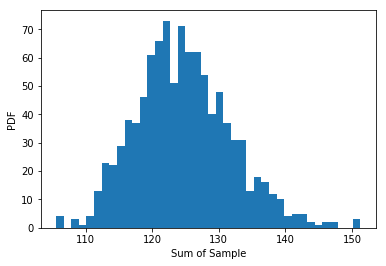

In [45]:
rv = stats.expon(1.5)
#rv = stats.lognorm(1.5)
#rv = stats.powerlaw(1.5)

# niters is the number of samples to simulate
niters = 1000
# n is the number of random variates per sample
n = 50
data = []
for _ in range(niters):
    sample = rv.rvs(size=n)
    data.append(np.sum(sample))
    
#plt.hist(data, bins=40, normed=True, cumulative=True)
plt.hist(data, bins=40)
plt.ylabel('PDF')
plt.xlabel('Sum of Sample')
plt.show()

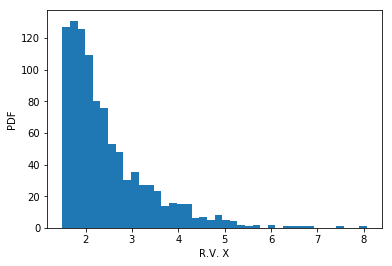

In [46]:
n=1000

sample = rv.rvs(size=n)
plt.hist(sample, bins=40)
plt.ylabel('PDF')
plt.xlabel('R.V. X')
plt.show()